157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


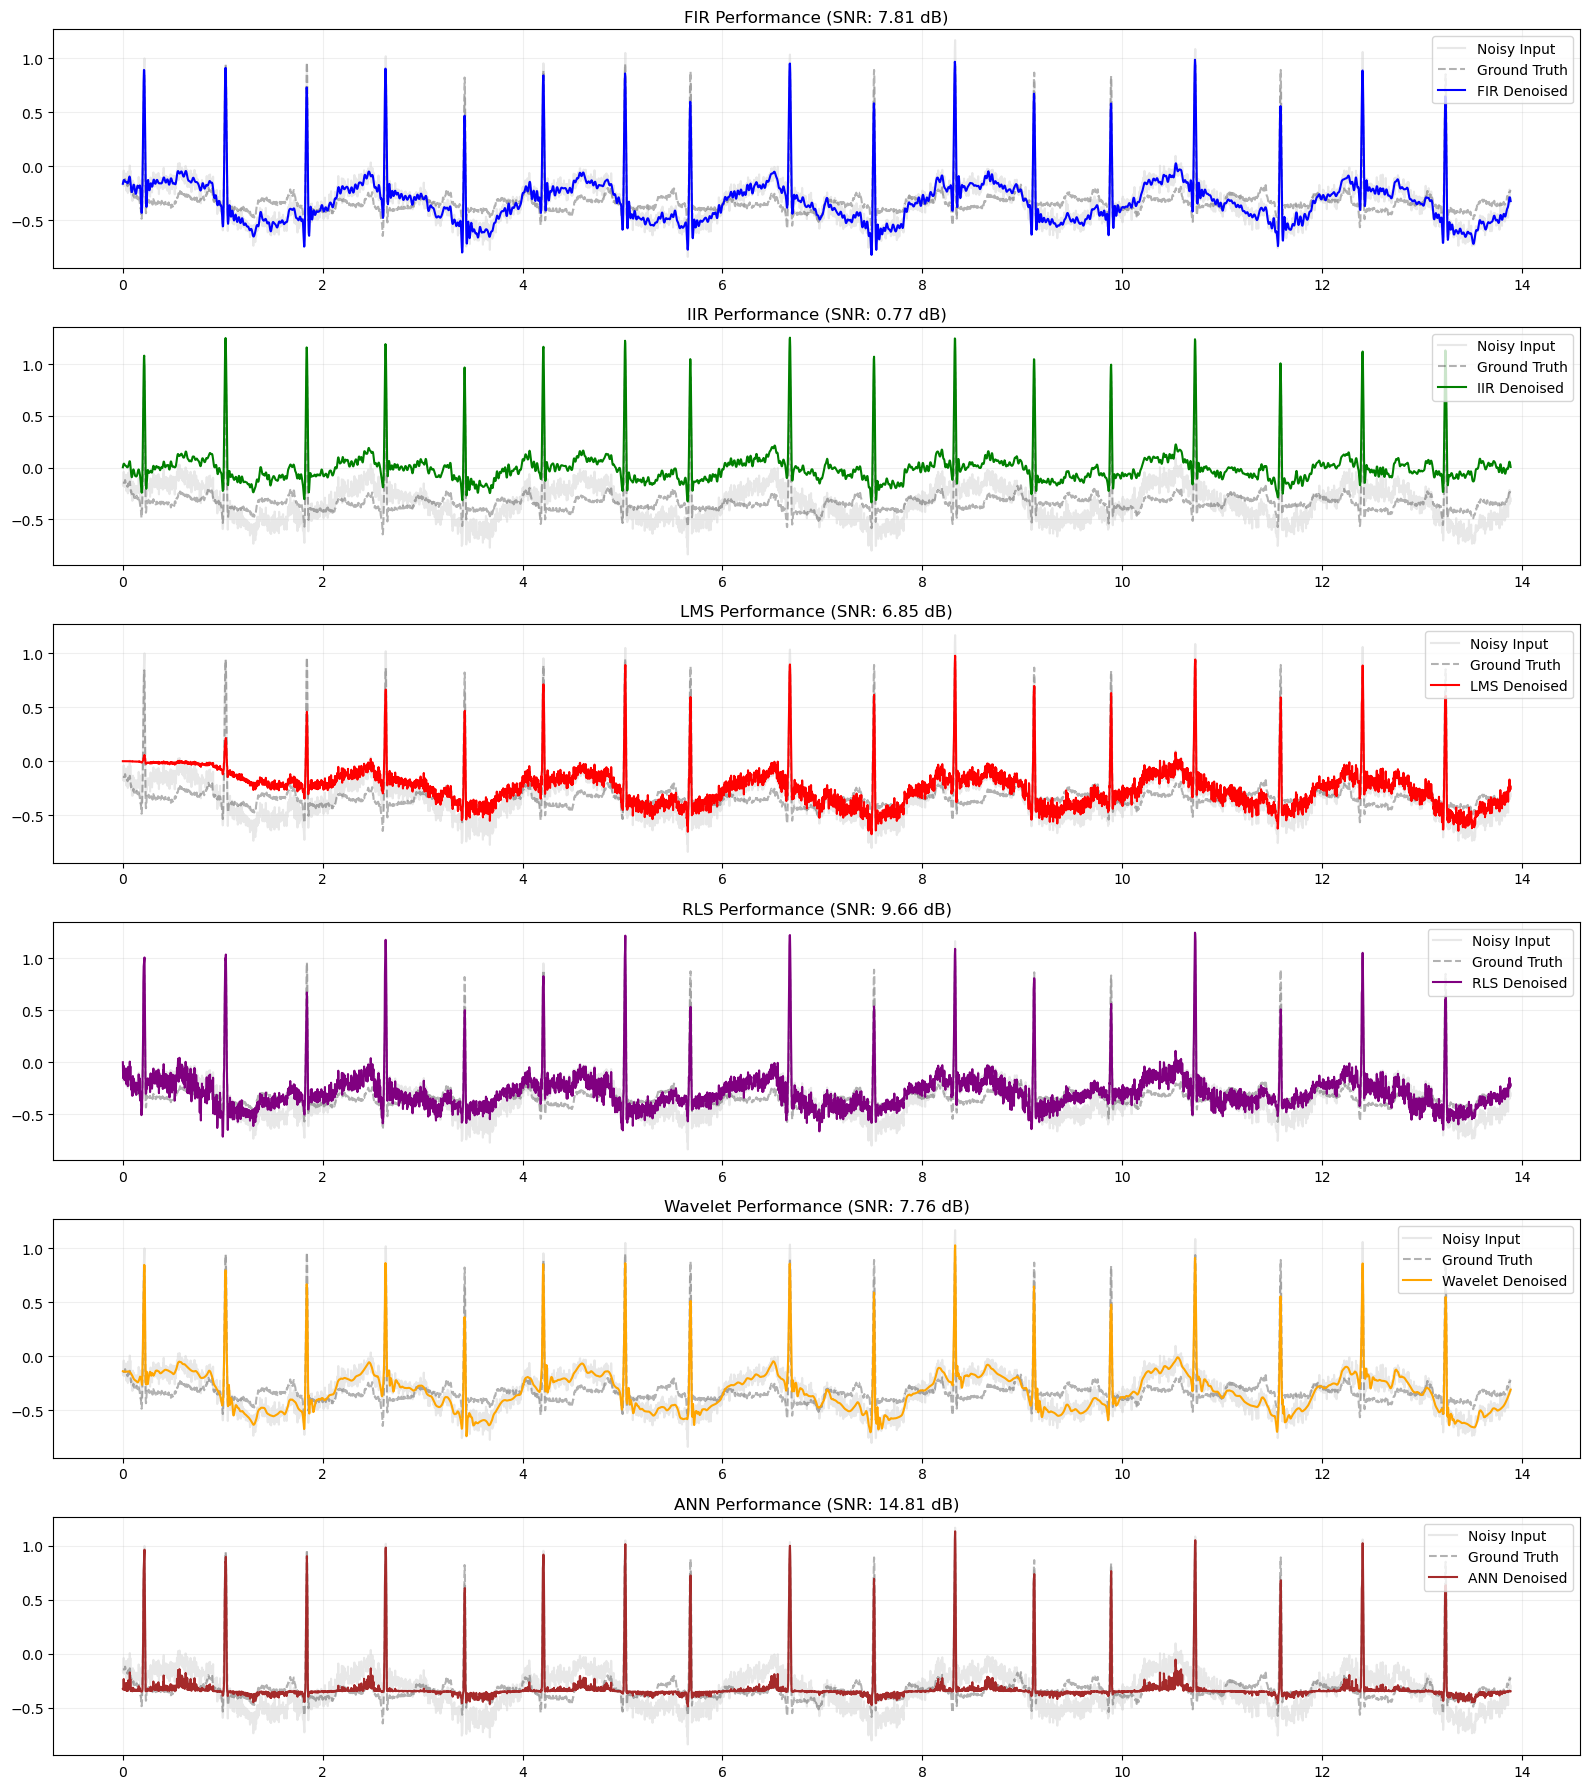


Method          | SNR (dB)   | RMSE       | Time (s)  
-------------------------------------------------------
Noisy Signal    | 7.57       | 0.1507     | 0.0       
FIR             | 7.81       | 0.1467     | 0.0037    
IIR             | 0.77       | 0.3299     | 0.0026    
LMS             | 6.85       | 0.1639     | 0.0741    
RLS             | 9.66       | 0.1185     | 0.1932    
Wavelet         | 7.76       | 0.1475     | 0.0011    
ANN             | 14.81      | 0.0655     | 12.888    


In [29]:
#Importing Libraries
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt
import padasip as pa
from sklearn.metrics import mean_squared_error
import time
import tensorflow as tf
from tensorflow.keras import layers, models, Input

#Loading Data
path = r"C:\Users\shah.kamal.BTRC\OneDrive - Bangladesh Telecommunication Regulatory Commission\saimum\Python\MIT BIH ECG\100"
record = wfdb.rdrecord(path)
ecg = record.p_signal[:, 0]
fs = record.fs #Sampling Frequency
N = 5000  #Number of samples to analyze
t = np.array([i / fs for i in range(N)])
clean_sig = ecg[:N]

#Noise Injection (AWGN + Baseline Wander)
noise_awgn = np.random.normal(0, 0.05, N)
baseline_wander = 0.2 * np.sin(2 * np.pi * 0.5 * t)
noisy_sig = clean_sig + noise_awgn + baseline_wander

#Results and Metrics Storage
results_data = {}
def get_stats(true, pred, start_t):
    exec_t = time.time() - start_t #Execution Time
    mse = mean_squared_error(true, pred) #Mean Squared Error
    snr = 10 * np.log10(np.sum(true**2) / np.sum((true - pred)**2)) #SNR
    return round(snr, 2), round(np.sqrt(mse), 4), round(exec_t, 4)

#---Processing Methods---

#FIR Filter
s = time.time()
fir_coeff = signal.firwin(101, 35, fs=fs, pass_zero='lowpass')
fir_out = signal.filtfilt(fir_coeff, 1.0, noisy_sig)
results_data["FIR"] = (fir_out, get_stats(clean_sig, fir_out, s))

#IIR Filter
s = time.time()
b, a = signal.butter(4, [0.5, 40], btype='bandpass', fs=fs)
iir_out = signal.filtfilt(b, a, noisy_sig)
results_data["IIR"] = (iir_out, get_stats(clean_sig, iir_out, s))

#LMS Adaptive
s = time.time()
f_lms = pa.filters.FilterLMS(n=1, mu=0.01, w="zeros")
lms_out, _, _ = f_lms.run(clean_sig, noisy_sig.reshape(-1, 1))
results_data["LMS"] = (lms_out.flatten(), get_stats(clean_sig, lms_out.flatten(), s))

#RLS Adaptive
s = time.time()
f_rls = pa.filters.FilterRLS(n=1, mu=0.99, w="zeros")
rls_out, _, _ = f_rls.run(clean_sig, noisy_sig.reshape(-1, 1))
results_data["RLS"] = (rls_out.flatten(), get_stats(clean_sig, rls_out.flatten(), s))

#Wavelet
s = time.time()
coeffs = pywt.wavedec(noisy_sig, 'db4', level=4)
sigma = np.median(np.abs(coeffs[-1])) / 0.6745
uthresh = sigma * np.sqrt(2 * np.log(N))
coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
wave_out = pywt.waverec(coeffs, 'db4')[:N]
results_data["Wavelet"] = (wave_out, get_stats(clean_sig, wave_out, s))

#ANN Method
s = time.time()
def norm(x): return (x - np.min(x)) / (np.max(x) - np.min(x))
ann_in, ann_target = norm(noisy_sig).reshape(-1, 1), norm(clean_sig).reshape(-1, 1)
model = models.Sequential([Input(shape=(1,)), layers.Dense(32, activation='relu'), 
                           layers.Dense(16, activation='relu'), layers.Dense(1, activation='linear')])
model.compile(optimizer='adam', loss='mse')
model.fit(ann_in, ann_target, epochs=20, verbose=0)
ann_res = model.predict(ann_in).flatten() * (np.max(clean_sig) - np.min(clean_sig)) + np.min(clean_sig)
results_data["ANN"] = (ann_res, get_stats(clean_sig, ann_res, s))

#---Visualization---

plt.figure(figsize=(16, 18))
plot_list = ["FIR", "IIR", "LMS", "RLS", "Wavelet", "ANN"]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

for i, name in enumerate(plot_list):
    plt.subplot(6, 1, i+1)
    plt.plot(t, noisy_sig, color='lightgray', label='Noisy Input', alpha=0.5)
    plt.plot(t, clean_sig, color='black', label='Ground Truth', alpha=0.3, linestyle='--')
    plt.plot(t, results_data[name][0], color=colors[i], label=f'{name} Denoised')
    plt.title(f"{name} Performance (SNR: {results_data[name][1][0]} dB)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

#---Performance Table---
print(f"\n{'Method':<15} | {'SNR (dB)':<10} | {'RMSE':<10} | {'Time (s)':<10}")
print("-" * 55)
noisy_snr = 10 * np.log10(np.sum(clean_sig**2) / np.sum((clean_sig - noisy_sig)**2))
print(f"{'Noisy Signal':<15} | {round(noisy_snr, 2):<10} | {round(np.sqrt(mean_squared_error(clean_sig, noisy_sig)), 4):<10} | {'0.0':<10}")
for name in plot_list:
    metrics = results_data[name][1]
    print(f"{name:<15} | {metrics[0]:<10} | {metrics[1]:<10} | {metrics[2]:<10}")